In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, QBC, RandomSampler
from skactiveml.utils import unlabeled_indices, call_func
from sklearn.datasets import load_digits
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from torch import nn

MISSING_LABEL = -1
RANDOM_STATE = 0

torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

# Deep Active Learning: Scikit-activeml with Skorch
In this brief tutorial, we show examplary show use-cases of our package
`skactiveml` with the Python package `skorch`, which is a scikit-learn
wrapper for Pytorch models. This ways, we are able to implement and test
deep learning model in combination with the query strategies in our framework.

## Loading Digit Data Set
For simplicity, we load the digit data set available through the `sklearn`
package. The 8x8 images show handwritten digits from 0 to 9 and the task is
to recognize the digits in the images.

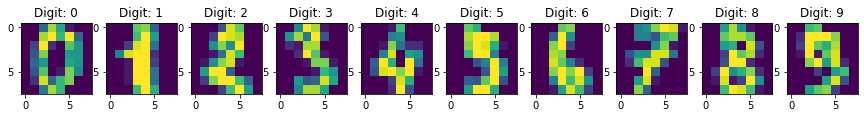

In [2]:
# Load digit data set.
X, y_true = load_digits(return_X_y=True)

# Visualize first 10 images.
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=10)
for i in range(10):
    axes[i].set_title(f'Digit: {y_true[i]}')
    axes[i].imshow(X[i].reshape((8, 8)))
plt.show()

# Standardize data.
X = StandardScaler().fit_transform(X)

# Reshape samples to n_samples x n_channels x width x height to fit skorch
# requirements.
X = X.reshape((len(X), 1, 8, 8))

# Set data types according to skorch requirements.
X, y_true = X.astype(np.float32), y_true.astype(np.int64)

# Identify list of possible classes.
classes = np.unique(y_true)

# Make a 66-34 train-test split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, train_size=0.66, random_state=RANDOM_STATE
)

## Convolutional Neural Network Ensemble
In a next step, we define a convolutional network (CNN) ensemble consisting of
multiple base CNNs with different learning rates and initializations.

In [3]:
# Define base module.
class ClassifierModule(nn.Module):
    def __init__(self):
        super(ClassifierModule, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dense_layer = nn.Linear(288, len(classes))
        self.outpout = nn.Softmax(dim=-1)

    def forward(self, X):
        X = self.conv_layer(X)
        X = X.reshape(X.size(0), -1)
        X= self.dense_layer(X)
        X = self.outpout(X)
        return X

# Create list of three base CNNs.
learning_rates = [1.e-3, 1.e-2, 1.e-1]
estimators = []
for i, learning_rate in enumerate(learning_rates):
    net = NeuralNetClassifier(
        ClassifierModule,
        max_epochs=100,
        lr=learning_rate,
        verbose=0,
        train_split=False,
    )
    net.initialize()
    estimators.append((f'clf {i}',
                       SklearnClassifier(
                           estimator=net, missing_label=MISSING_LABEL,
                           random_state=i, classes=classes)
                       )
                      )

# Creat voting ensemble out of given ensemble list.
ensemble = SklearnClassifier(
    estimator=VotingClassifier(estimators=estimators, voting='soft'),
    missing_label=MISSING_LABEL, random_state=RANDOM_STATE, classes=classes
)

## Pool-based Active Learning
For our ensemble, we evaluate three different query strategies, i.e., random
sampling, uncertainty sample, and query-by-committee, regarding their sample
selection. For this purpose, we start with zero labels and make 20 iterations
of an active learning cycle with a batch size of 20.

There are warnings because initially there is no training data, i.e., zero
labels, such that random predictions are made.

In [4]:
# Define setup.
n_cycles = 25
batch_size = 20
qs_dict = {
    'random sampling': RandomSampler(random_state=RANDOM_STATE),
    'uncertainty sampling': UncertaintySampling(random_state=RANDOM_STATE),
    'query-by-committee': QBC(random_state=RANDOM_STATE)
}
acc_dict = {
    'random sampling': np.zeros(n_cycles + 1),
    'uncertainty sampling': np.zeros(n_cycles + 1),
    'query-by-committee': np.zeros(n_cycles + 1)
}

# Perform active learning with each query strategy.
for qs_name, qs in qs_dict.items():
    print(f'Execute active learning using {qs_name}.')

    # Create array of missing labels as initial labels.
    y = np.full_like(y_train, fill_value=MISSING_LABEL, dtype=np.int64)

    # Execute active learning cycle.
    for c in range(n_cycles):
        # Fit and evaluate ensemble.
        acc = ensemble.fit(X_train, y).score(X_test, y_test)
        acc_dict[qs_name][c] = acc

        # Select and update training data.
        unlbld_idx = unlabeled_indices(y, missing_label=MISSING_LABEL)
        X_cand = X[unlbld_idx]
        query_idx = unlbld_idx[
         call_func(
             qs.query, X_cand=X_cand, clf=ensemble, ensemble=ensemble,
             batch_size=batch_size
         )
        ]
        y[query_idx] = y_train[query_idx]

    # Fit and evaluate ensemble.
    ensemble.fit(X_train, y)
    acc_dict[qs_name][n_cycles] = ensemble.score(X_test, y_test)

Execute active learning using random sampling.


/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:267: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.
  warnings.warn("The 'base_estimator' could not be fitted because of"
/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:184: UserWarning: Since the 'base_estimator' could not be fitted when calling the `fit` method, the class label distribution`_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]` is used to make the predictions.
  warnings.warn(


Execute active learning using uncertainty sampling.


/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:267: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.
  warnings.warn("The 'base_estimator' could not be fitted because of"
/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:184: UserWarning: Since the 'base_estimator' could not be fitted when calling the `fit` method, the class label distribution`_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]` is used to make the predictions.
  warnings.warn(
/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:184: UserWarning: Since the 'base_estimator' could not be fitted when calling the `fit` method, the class label distribution`_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]` is used to make the predictions.

Execute active learning using query-by-committee.


/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:267: UserWarning: The 'base_estimator' could not be fitted because of 'There is no labeled data.'. Therefore, the class labels of the samples are counted and will be used to make predictions. The class label distribution is `_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`.
  warnings.warn("The 'base_estimator' could not be fitted because of"
/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:184: UserWarning: Since the 'base_estimator' could not be fitted when calling the `fit` method, the class label distribution`_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]` is used to make the predictions.
  warnings.warn(
/home/marek/Projects/GitHub/scikit-activeml/skactiveml/classifier/_wrapper.py:184: UserWarning: Since the 'base_estimator' could not be fitted when calling the `fit` method, the class label distribution`_label_counts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]` is used to make the predictions.

## Visualize Results
In the following, we plot the obtained learning curves including the area
under learning curve (AULC) scores per query strategy.

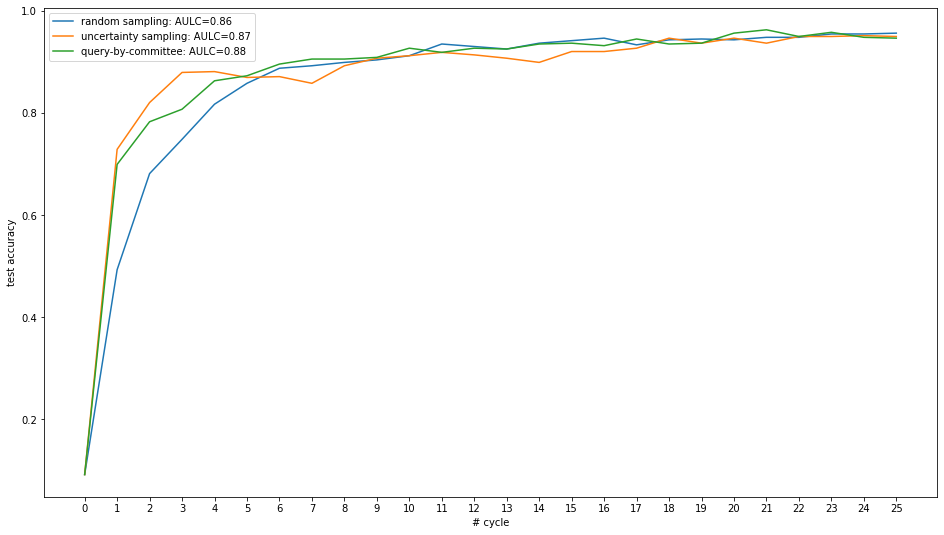

In [5]:
cycles = np.arange(n_cycles + 1, dtype=int)
plt.figure(figsize=(16, 9))
for qs_name, acc in acc_dict.items():
    plt.plot(cycles, acc, label=f'{qs_name}: AULC={round(acc.mean(), 2)}')
plt.xticks(cycles)
plt.xlabel('# cycle')
plt.ylabel('test accuracy')
plt.legend()
plt.show()